# Comparing our samplers on various energy functions

In this notebook we explore the behaviour of our different sampling methods when applied to a variety of standard energy functions from the literature. 

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K

from pysgmcmc.samplers.sghmc import SGHMCSampler
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pysgmcmc.samplers.sgld import SGLDSampler
from pysgmcmc.samplers.sghmchd import SGHMCHDSampler

from pysgmcmc.samplers.energy_functions import (
    Banana, Gmm1, Gmm2, Gmm3, MoGL2HMC, 
    to_negative_log_likelihood
)
from pysgmcmc.diagnostics import PYSGMCMCTrace



ENERGY_FUNCTIONS = {
    "banana": (
        Banana(),
        lambda: [K.random_normal_variable(shape=(1,), mean=0., scale=1.,), K.random_normal_variable(shape=(1,), mean=0., scale=1.,)],
        lambda samples: plt.scatter(samples[:, 0], samples[:, 1]),
    ),
    "gmm1": (
        Gmm1(),
        lambda: [K.variable(K.random_normal((1,)))],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
    "gmm2": (
        Gmm2(),
        lambda: [K.variable(K.random_normal((1,)))],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
    "gmm3": (
        Gmm3(),
        lambda: [K.variable(K.random_normal((1,)))],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
    "mog-l2hmc": (
        MoGL2HMC(),
        lambda: [K.variable(K.random_normal((1,)))],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
}

SAMPLERS = (
    SGHMCHDSampler, SGHMCSampler, SGLDSampler, #RelativisticSGHMCSampler
)


def sample(sampler, n_samples=10**5, burn_in_steps=0, keep_every=1):
    _ = list(islice(sampler, burn_in_steps))
    return np.asarray([sample for _, sample in islice(sampler, keep_every, n_samples * keep_every + keep_every)])

def plot_samplers(function_name):
    energy_function, initial_guess, plot_samples = ENERGY_FUNCTIONS[function_name]

    for sampler in SAMPLERS:
        initial_sample = initial_guess()
        loss = to_negative_log_likelihood(energy_function)(initial_sample)
        samples = np.squeeze(sample(sampler(loss=loss, params=initial_sample, lr=0.01, burn_in_steps=3000)))
        energy_function.plot()
        plot_samples(samples)
        plt.title(sampler.__name__)
        plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Banana
Below we give sample based approximation of a banana shaped function.

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


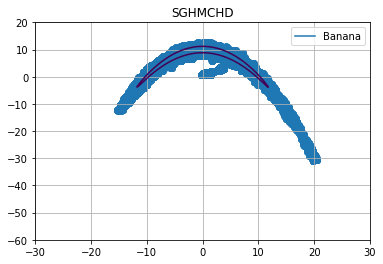

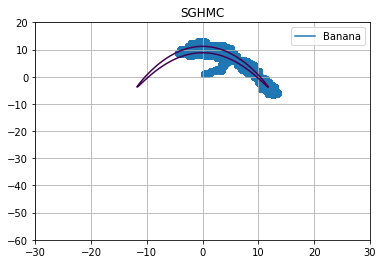

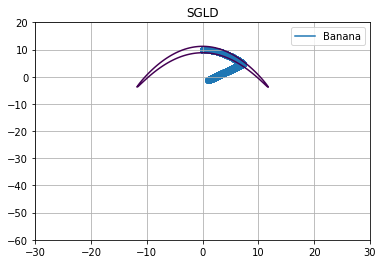

In [ ]:
plot_samplers("banana")

## Gaussian Mixtures

Below we show plots of a sample-based approximation of a Gaussian mixture with means `(-5, 0, 5)` and 
equal variances of `(1, 1, 1)`.

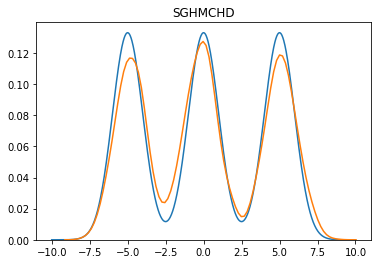

In [ ]:
plot_samplers("gmm1")

Next, we decrease the variances of the component gaussians to `(1.0 / 0.5, 0.5, 1.0 / 0.5)` while keeping all means the same.

In [ ]:
plot_samplers("gmm2")

Next, we decrease the variances of the component gaussians to `(1.0 / 0.3, 0.3, 1.0 / 0.3)` while keeping all means the same.

In [ ]:
plot_samplers("gmm3")

Next, we try an extra-hard mixture of gaussians, introduced in the L2HMC paper. 
Variance of both gaussians is `0.1` and the two means are distance `4` (`12` standard deviations) apart. This makes it nearly impossible to mix between modes.

In [ ]:
plot_samplers("mog-l2hmc")

Next, we test our samplers on energy functions introduced in the L2HMC paper. We start with their rough well function.